#### IMPORTAÇÃO DAS BIBLIOTECAS

In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import defaultdict

#### IMPORTAÇÃO DOS DADOS

In [2]:
# Diretório onde estão localizados os arquivos .xls
diretorio = 'xls_files/'

# Lista de todos os arquivos no diretório
arquivos = os.listdir(diretorio)

# Verificação se já existem arquivos com a extensão .xlsx na pasta
if any(arquivo.endswith('.xlsx') for arquivo in arquivos):
    print("Já existem arquivos com a extensão .xlsx na pasta")
else:
    # Iteração sobre cada arquivo
    for arquivo in arquivos:
        # Checagem da extensão do arquivo ".xls"
        if arquivo.endswith('.xls'):
            # Carrega o arquivo .xls em um DataFrame usando o pandas
            df = pd.read_excel(os.path.join(diretorio, arquivo))

            # Define o caminho para salvar o arquivo com extensão .xlsx
            novo_nome = os.path.splitext(arquivo)[0] + '.xlsx'
            novo_caminho = os.path.join(diretorio, novo_nome)

            # Salva o DataFrame como um arquivo .xlsx
            df.to_excel(novo_caminho, index=False)

            print(f'O arquivo {arquivo} foi convertido para {novo_nome}')

Já existem arquivos com a extensão .xlsx na pasta


In [3]:
# Caminho dos arquivos .xls
path = "xls_files"
# Lista de todos os arquivos que há no diretório
files = os.listdir(path)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
print(files_xlsx)

['MoS2 mV HER 1 - 1000.xlsx', 'MoS2 mV HER 1001 - 2000.xlsx', 'MoS2 mV HER 2001 - 2335.xlsx', 'MoS2 mV HER.xlsx']


In [4]:
# Lista dos arquivos em .xlsx
df_list = []

# Compilação dos arquivos
for f in files_xlsx:
    data = pd.read_excel(os.path.join(path, f))
    df_list.append(data)
df = pd.concat(df_list)

In [5]:
# Verifica se já existe o arquivo na pasta para não sobrescrevê-lo, evitando duplicar os dados
NOME_ARQUIVO_CONTATENADO = "MoS2 mV HER.xlsx"
if f"{NOME_ARQUIVO_CONTATENADO}" in files_xlsx:
    print("Já existe o arquivo na pasta")
else:
    output_path = f"xls_files/{NOME_ARQUIVO_CONTATENADO}"
    df.to_excel(output_path, index=False)

Já existe o arquivo na pasta


In [6]:
# Leitura do arquivo e exclusão de dados faltantes (NAN)
df_HER = pd.read_excel("xls_files/MoS2 mV HER.xlsx")
df_HER = df_HER.dropna(axis = 1, how = 'all')
#print(df_HER)

In [7]:
# Converte os abstracts no formato string
df_HER['Abstract'] = df_HER['Abstract'].astype("string")
print(df_HER['Abstract'])

0       It is of great significance for the developmen...
1       Highly active and earth-abundant catalysts for...
2       Molybdenum disulfide (MoS2) with metallic 1T p...
3       Herein we report a heterostructure with ultrat...
4       A binder free electrode is fabricated by plant...
                              ...                        
2330    2D semiconductors with atomically thin body th...
2331    The rational engineering of 2D amorphous/amorp...
2332    High-performance n-type molybdenum disulfide a...
2333    To achieve advanced functionalities in nanostr...
2334    We have performed a systematic study to analyz...
Name: Abstract, Length: 2335, dtype: string


#### ANÁLISE DOS DADOS DE SOBREPOTENCIAIS

           Material  Sobrepotencial (mV)
0        MoS2/Co9S8                 73.0
1      MoS2/COF-C4N                106.0
2      MoS2/COF-C4N                349.0
3  CdS@CoMo2S4/MoS2                172.0
4       Ni-MoS2-RGO                349.0
           Material  Sobrepotencial (mV)
0        MoS2/Co9S8                 73.0
1      MoS2/COF-C4N                106.0
2  CdS@CoMo2S4/MoS2                172.0
3       Ni-MoS2-RGO                349.0
4              MoS2                300.0


C:\Users\raphaella220046\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


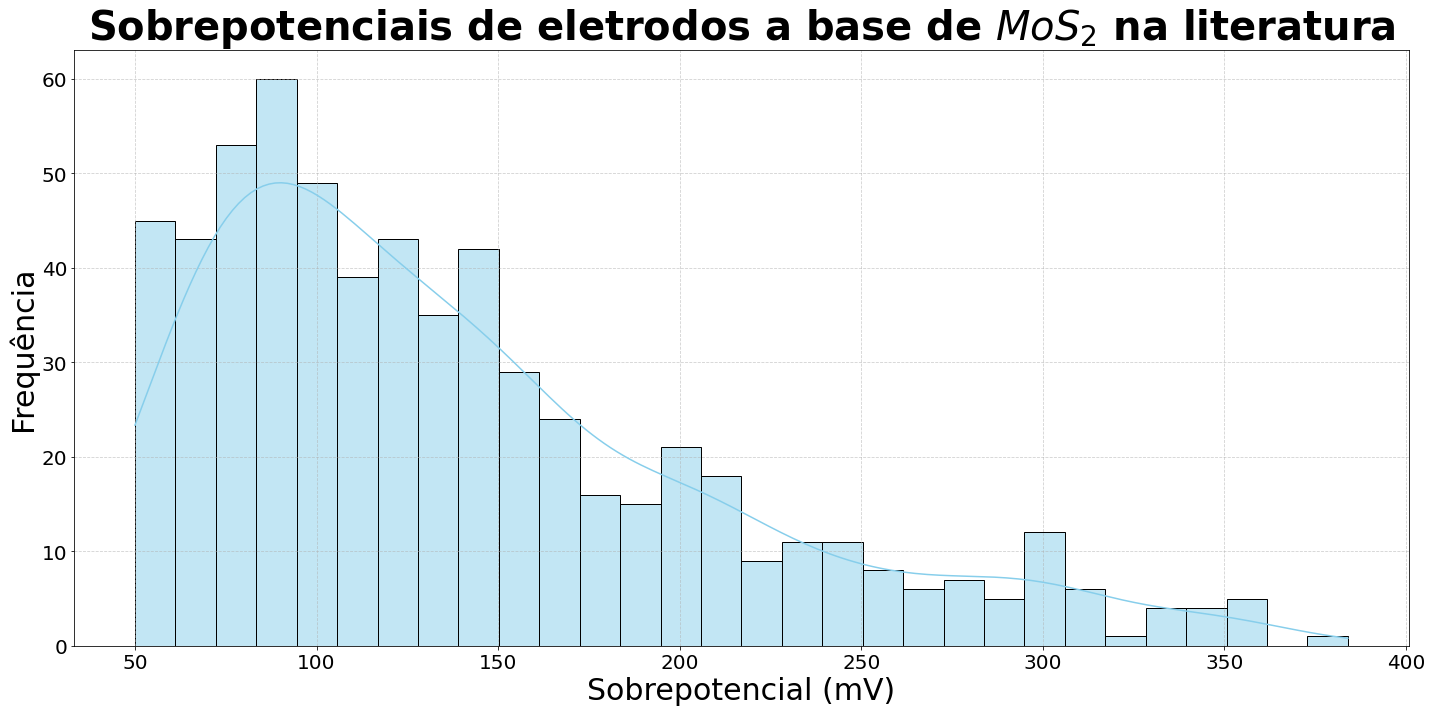

média filtrados: 140.11
desvio padrão filtrados: 71.23
mínimo filtrados: 50.0
máximo filtrados: 384.0


622

In [8]:
# Caminho do arquivo XLSX
file_path = "xls_files/MoS2 mV HER.xlsx"

# Leitura do arquivo XLSX
df_HER = pd.read_excel(file_path)

# Regex para capturar os nomes dos materiais no título (MoS2 com ou sem outros materiais adicionais)
regex_material = r'[\w@/-]*MoS2[\w@/-]*'

# Regex para capturar o sobrepotencial no abstract, permitindo variações em "overpotential" (case-insensitive)
regex_overpotential = r'(?i)(overpotential.*?(\d+(?:\.\d+)?))\s*mV'

# Lista para armazenar os materiais e seus respectivos sobrepotenciais
resultados = []

# Função para dividir o abstract em várias frases para facilitar a busca de termos
def dividir_em_frases(texto):
    # Divisão considerando diferentes tipos de pontuação
    return re.split(r'(?<=[.!?;])\s+', texto)

# Função para remover outliers usando Z-Score
def remover_outliers_zscore(df, coluna, limiar=3):
    """
    Função para remover outliers usando o método Z-Score.
    
    Parâmetros:
    - df: DataFrame com os dados.
    - coluna: Nome da coluna onde será aplicada a remoção de outliers.
    - limiar: Limiar do z-score acima do qual os valores são considerados outliers (default é 3).
    
    Retorna:
    - DataFrame sem os outliers.
    """
    # Cálculo da média e o desvio padrão da coluna
    media = df[coluna].mean()
    desvio_padrao = df[coluna].std()
    
    # Cálculo do z-score
    z_scores = (df[coluna] - media) / desvio_padrao
    
    # Filtro dos dados para remover os outliers
    df_sem_outliers = df[np.abs(z_scores) <= limiar]
    
    return df_sem_outliers

# Iterar sobre o DataFrame e capturar os dados
for idx, row in df_HER.iterrows():
    # Tentar capturar o título e o abstract da linha
    titulo = row.get('Article Title', '')
    abstract = row.get('Abstract', '')
    
    # Verificar se o título contém algum material relevante
    if pd.notna(titulo) and pd.notna(abstract):  # Verificar se o título e o abstract não são NaN
        materiais_encontrados = re.findall(regex_material, titulo)
        
        # Para cada material encontrado no título, buscar o sobrepotencial no abstract
        for material in materiais_encontrados:
            # Dividir o abstract em frases para facilitar a análise
            frases = dividir_em_frases(abstract)
            
            # Verifica cada frase para encontrar a palavra 'overpotential' e o valor de mV
            for frase in frases:
                # Procurar pelo valor de overpotential na frase
                matches_overpotential = re.findall(regex_overpotential, frase)
                
                # Se encontrar um valor de sobrepotencial, adicionar o material e o valor
                if matches_overpotential:
                    for match in matches_overpotential:
                        valor_overpotential = match[1]  # O valor capturado em mV
                        if valor_overpotential:
                            # Adiciona o material encontrado e o valor de sobrepotencial
                            resultados.append((material.strip(), float(valor_overpotential)))  # Armazenar como tupla (material, sobrepotencial)

# Cria um DataFrame com os resultados
df_resultados = pd.DataFrame(resultados, columns=['Material', 'Sobrepotencial (mV)'])

# Filtra valores de sobrepotencial maiores que 50 mV
df_resultados_filtrados = df_resultados[df_resultados['Sobrepotencial (mV)'] >= 50]

# Exibe os primeiros resultados
print(df_resultados_filtrados.head())

# Remove outliers usando Z-Score
df_resultados_sem_outliers = remover_outliers_zscore(df_resultados_filtrados, 'Sobrepotencial (mV)', limiar=3)

# Exclui os nomes repetidos mantendo o menor valor
resultados_filtrados = []
ultimo_material = None
ultimo_sobrepotencial = None

for material, sobrepotencial in df_resultados_sem_outliers.itertuples(index=False):
    if material != ultimo_material:
        # Se o material não for o mesmo do anterior, adiciona diretamente
        resultados_filtrados.append((material, sobrepotencial))
        ultimo_material = material
        ultimo_sobrepotencial = sobrepotencial
    else:
        # Se o material for o mesmo, mantém o menor sobrepotencial
        if sobrepotencial < ultimo_sobrepotencial:
            resultados_filtrados[-1] = (material, sobrepotencial)  # Substitui o último
            ultimo_sobrepotencial = sobrepotencial

# Cria DataFrame com os resultados filtrados
df_resultados_filtrados = pd.DataFrame(resultados_filtrados, columns=['Material', 'Sobrepotencial (mV)'])

# Exibe os primeiros resultados filtrados
print(df_resultados_filtrados.head())

# Plota o histograma dos sobrepotenciais encontrados
plt.figure(figsize=(20, 10))
sns.histplot(df_resultados_filtrados['Sobrepotencial (mV)'], bins=30, kde=True, color='skyblue', edgecolor='black')

# Configuração do gráfico
plt.title(r'Sobrepotenciais de eletrodos a base de $MoS_2$ na literatura', fontsize=40, fontweight='bold')
plt.xlabel('Sobrepotencial (mV)', fontsize=30)
plt.ylabel('Frequência', fontsize=30)
plt.tick_params(labelsize=20)
plt.rcParams['legend.fontsize'] = 20
plt.grid(True, linestyle='--', alpha=0.6)  # Adicionando uma grade
plt.tight_layout()

# Salva o histograma em um arquivo
plt.savefig('distribuicao_sobrepotenciais_MoS2_literatura.png', dpi=300, bbox_inches='tight', pad_inches=0)

# Exibe o histograma
plt.show()

# Salvar os resultados filtrados em um arquivo CSV
df_resultados_filtrados.to_csv('Materiais_e_sobrepotenciais.csv', index=False)

# Exibir estatísticas dos sobrepotenciais filtrados
print("média filtrados:", round(np.mean(df_resultados_filtrados['Sobrepotencial (mV)']),2))
print("desvio padrão filtrados:", round(np.std(df_resultados_filtrados['Sobrepotencial (mV)']),2))
print("mínimo filtrados:", np.min(df_resultados_filtrados['Sobrepotencial (mV)']))
print("máximo filtrados:", np.max(df_resultados_filtrados['Sobrepotencial (mV)']))

len(df_resultados_filtrados)

#### WORDCLOUD DOS MATERIAIS A BASE DE MoS2

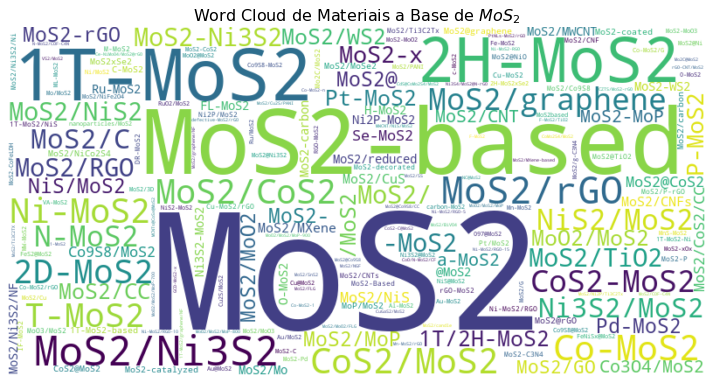

            Material  Frequência
1               MoS2        1268
31        MoS2-based         139
41           1T-MoS2          80
6            2H-MoS2          59
236       MoS2/Ni3S2          19
...              ...         ...
1214       MoO2-MoS2           1
1215       bulk-MoS2           1
1216  CoS2/SnO2@MoS2           1
1217    2H-MoS2/MoOx           1
1218    MoS2-Cu2S-CC           1

[1251 rows x 2 columns]


In [9]:
# Dicionário para armazenar a frequência dos materiais
frequencia_materiais = {}

# Iterar sobre o DataFrame e capturar os dados
for idx, row in df_HER.iterrows():
    # Tentar capturar o abstract da linha
    abstract = row.get('Abstract', '')
    
    # Verificar se o abstract não é NaN
    if pd.notna(abstract):
        # Encontrar os materiais únicos no abstract (considerar apenas uma vez por abstract)
        materiais_encontrados = set(re.findall(regex_material, abstract))
        
        # Atualizar a frequência dos materiais no dicionário
        for material in materiais_encontrados:
            frequencia_materiais[material] = frequencia_materiais.get(material, 0) + 1

# Criar um DataFrame com os resultados dos materiais e suas frequências
df_materiais = pd.DataFrame(list(frequencia_materiais.items()), columns=['Material', 'Frequência'])

# Ordenar por frequência em ordem decrescente
df_materiais = df_materiais.sort_values(by='Frequência', ascending=False)

# Gerar a word cloud com base nas frequências
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(frequencia_materiais)

# Plotar a word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(r'Word Cloud de Materiais a Base de $MoS_2$', fontsize=16)
plt.tight_layout()

# Exibir a word cloud
plt.show()

# Salvar a word cloud como imagem
wordcloud.to_file('Materiais_a_base_de_MoS2.png')

# Exportar a frequência dos materiais para CSV
df_materiais.to_csv('frequencia_materiais_por_abstract.csv', index=False)

# Exibir os dados de frequência
print(df_materiais)